# Topic Modeling and Sentiment Analysis of Extinction Rebellion Tweets (2019–2023)

**Group Members:** Sebastiaan Geleedst (1141686),
Daniela Donosaite (1221760),
Jochem Vis (1387588),
Sam Aivazi (0738697)


Instructor Name: Dennis Nguyen






This study follows the approach of Singh et al. (2019) to analyze #ExtinctionRebellion tweets using K-means clustering and LDA for event detection and sentiment analysis to track shifts in public sentiment. These methods are applied to five datasets, each representing a specific time period. By combining the results of these techniques, the study examines how effectively they can identify and predict events and sentiment changes.

**Research Question:**
"How effectively can topic modelling and sentiment analysis of #ExtinctionRebellion tweets identify and predict real-world events and shifts in public sentiment?"

**Table of Contents:**
1. Loading the Data
2. Analyzing the Distribution of Tweets (focus on date)
3. Preprocessing
4. Event Detection with K-means and LDA
5. Sentiment Analysis


## 1. Loading the dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import nltk
import re
import spacy
import random
from collections import Counter

!pip install kneed
!pip install vaderSentiment
!pip install pyLDAvis -qq
!pip install -qq -U gensim
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!pip install -U scikit-learn
!python -m spacy download en_core_web_md -qq

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from kneed import KneeLocator

import pyLDAvis.gensim_models
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

random.seed(0)
np.random.seed(0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
DF = pd.read_csv('ExtinctionRebellion.csv', engine='python', encoding='utf-8', on_bad_lines='skip')

print(DF.head())
print(DF.info)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   Unnamed: 0             tweet_id  \
0           1  1079902486880837637   
1           2  1079895994110697472   
2           3  1079895698181636096   
3           4  1079894571570597889   
4           5  1079894157009784837   

                                                text            author_id  \
0  My new years resolution - Rebel for Life on Ea...           3183622761   
1  World scientists’ warning to humanity - Greenp...            172081908   
2  Happy #Veganuary to everyone\r\n\r\n#AnimalFar...             73123998   
3  Imagine getting those 2 million people to part...           1835080920   
4  Thank you @ExtinctionR  &amp; Happy New Year! ...  1034036824082145280   

     user_username                created_at sourcetweet_type  \
0     forfoxsakery  2019-01-01T00:49:51.000Z           quoted   
1   Jackthelad1947  2019-01-01T00:24:03.000Z              NaN   
2  TheStoppedClock  2019-01-01T00:22:52.000Z              NaN   
3           keduzi  2019-01-01T00:18:23.000Z    

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
DF.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,tweet_id,text,author_id,user_username,created_at,sourcetweet_type,sourcetweet_text,lang
0,1,1079902486880837637,My new years resolution - Rebel for Life on Ea...,3183622761,forfoxsakery,2019-01-01T00:49:51.000Z,quoted,PRESS RELEASE: Make ‘Rebel for Life on Earth’ ...,en
1,2,1079895994110697472,World scientists’ warning to humanity - Greenp...,172081908,Jackthelad1947,2019-01-01T00:24:03.000Z,NaN,NaN,en
2,3,1079895698181636096,Happy #Veganuary to everyone\r\n\r\n#AnimalFar...,73123998,TheStoppedClock,2019-01-01T00:22:52.000Z,NaN,NaN,en
3,4,1079894571570597889,Imagine getting those 2 million people to part...,1835080920,keduzi,2019-01-01T00:18:23.000Z,quoted,Petition launched to protest at France’s failu...,en
4,5,1079894157009784837,Thank you @ExtinctionR &amp; Happy New Year! ...,1034036824082145280,jaksphillips,2019-01-01T00:16:45.000Z,NaN,NaN,en


## 2. Tweets Distribution

The monthly distribution of tweets is analyzed to identify trends in tweet volume across different months. By examining these fluctuations, it is possible to determine whether peaks in tweet activity align with significant events from the Extinction Rebellion timeline. If clear correlations emerge between spikes in tweet volume and events, this could indicate that Twitter activity serves as a useful signal for detecting and analyzing key moments in the movement’s activities.

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-26-9f8e3aa059ef>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  DF['year_month'] = DF['created_at'].dt.to_period('M')


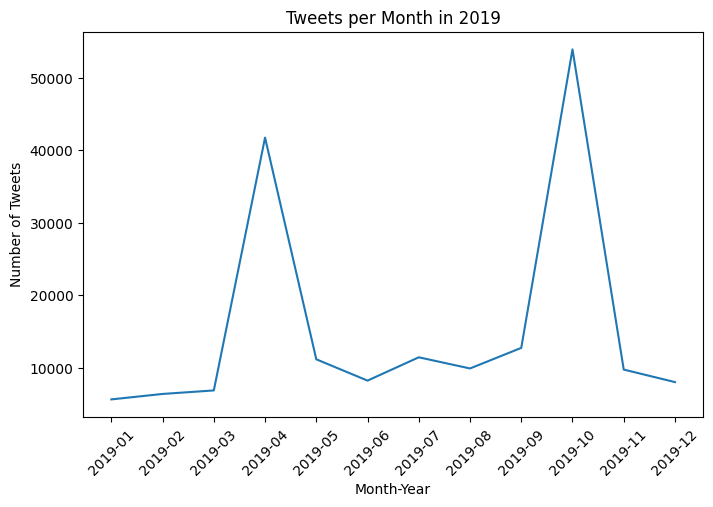

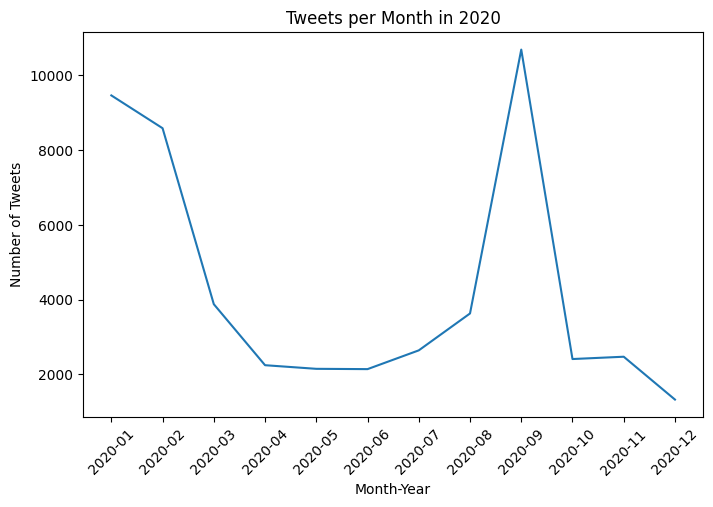

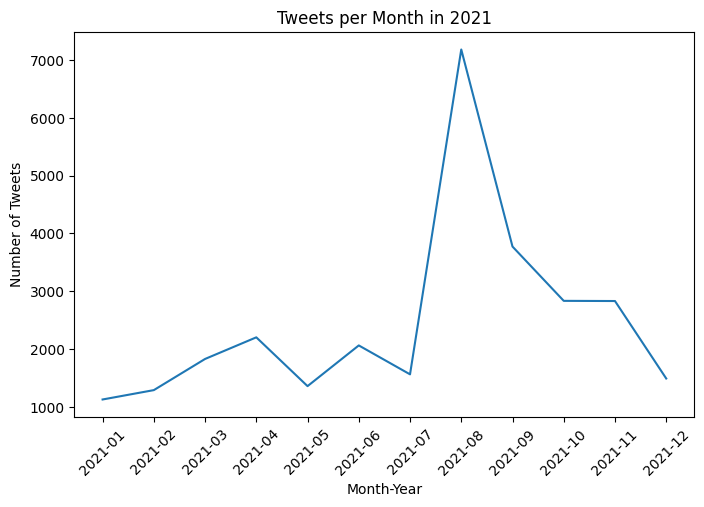

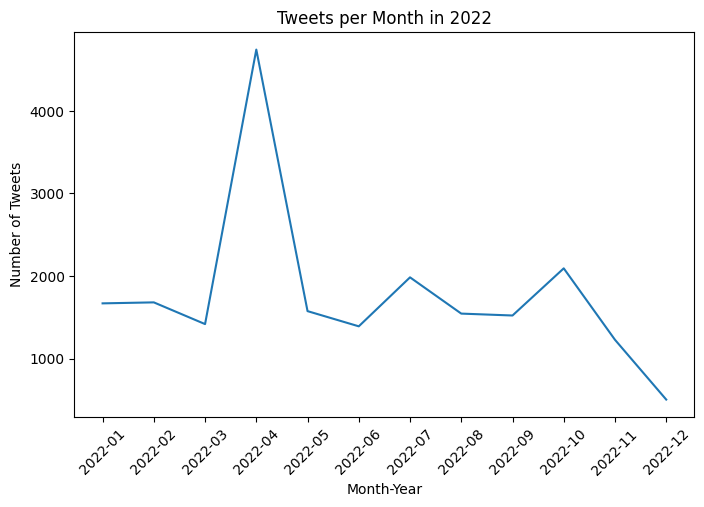

In [ ]:
# Convert 'created_at' column to datetime format
DF['created_at'] = pd.to_datetime(DF['created_at'])

# Extract year and month for grouping
DF['year_month'] = DF['created_at'].dt.to_period('M')
years = DF['created_at'].dt.year.unique()  # Get unique years in the dataset

# Loop through each year to analyze tweets per month
for year in years:
    year_data = DF[DF['created_at'].dt.year == year]  # Filter data for the specific year

    # Count the number of tweets per month
    x, y = np.unique(year_data['year_month'], return_counts=True)

    # Plot the monthly tweet distribution
    plt.figure(figsize=(8, 5))
    plt.plot(x.astype(str), y)
    plt.xticks(rotation=45)
    plt.xlabel("Month-Year")
    plt.ylabel("Number of Tweets")
    plt.title(f"Tweets per Month in {year}")
    plt.show()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


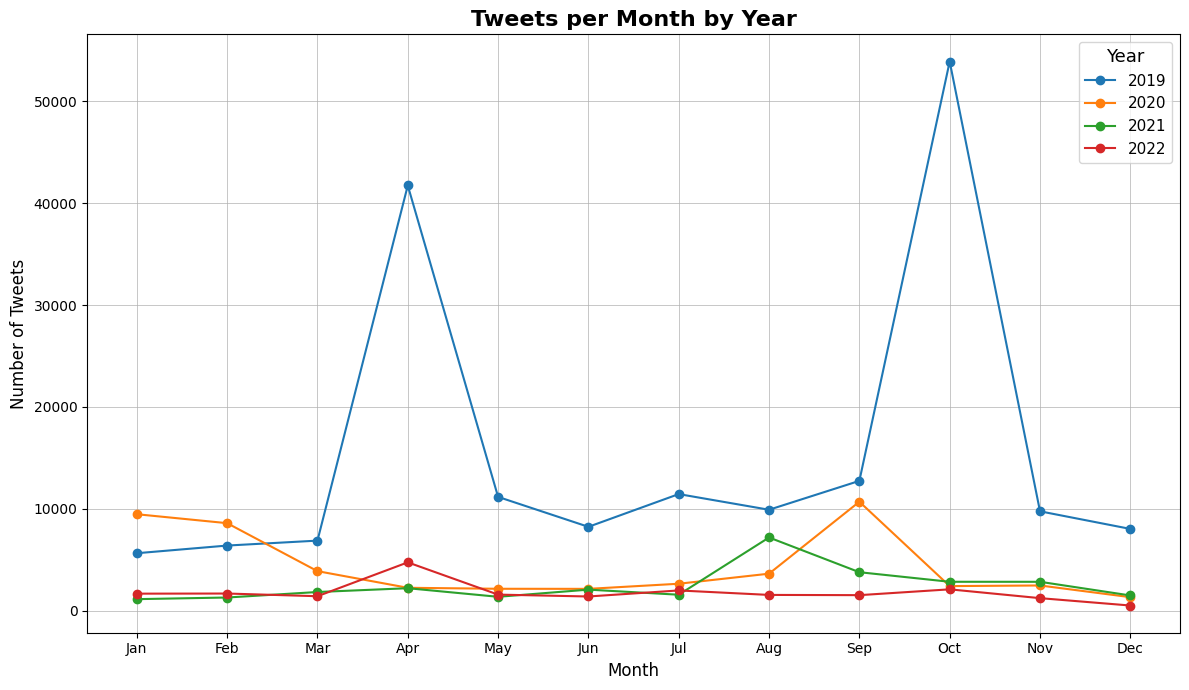

In [ ]:
# Extract year and month
DF['year'] = DF['created_at'].dt.year
DF['month'] = DF['created_at'].dt.month

# Group by year and month to count the number of tweets per month per year
monthly_counts = DF.groupby(['year', 'month']).size().unstack(fill_value=0)

# Set up the plot
plt.figure(figsize=(12, 7))

# Plot each year as a separate line
for year in monthly_counts.index:
    plt.plot(monthly_counts.columns, monthly_counts.loc[year], label=str(year), marker='o', markersize=6)

# Customize the plot
plt.title("Tweets per Month by Year", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, which='both', linestyle='-', linewidth=0.5)

# Add a legend
plt.legend(title="Year", title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-3e57d4a79f56>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  DF['month_year'] = DF['created_at'].dt.to_period('M')  # Converts to month-year format (e.g., '2019-01')


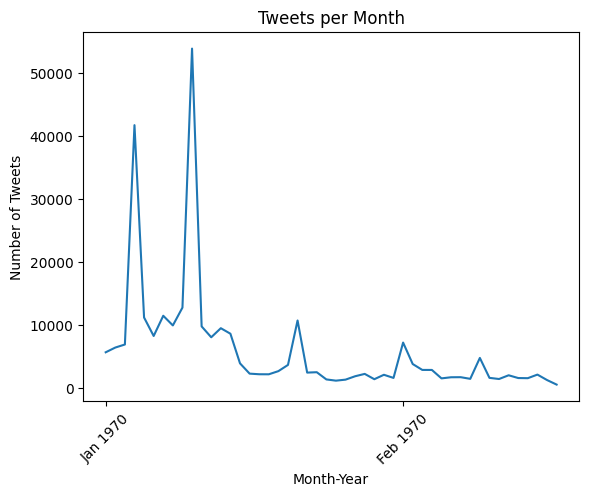

In [ ]:
# Extract date or month-year format
DF['month_year'] = DF['created_at'].dt.to_period('M')  # Converts to month-year format (e.g., '2019-01')

# Get tweet counts for each month
x, y = np.unique(DF['month_year'], return_counts=True)

# Plot
plt.plot(x.astype(str), y)

# Set x-axis locator and formatter for better formatting of month-year labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Place ticks on each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as Month Year (e.g., Jan 2019)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets")
plt.title("Tweets per Month")

plt.show()

## 3. Preproccesing

The preprocessing phase prepares the dataset for analysis by minimizing noise and structuring the text data. Each subset, representing a specific time period, is filtered based on relevant dates, as outlined in the "Timeline of Extinction Rebellion Actions." This ensures that only tweets directly related to specific events are included, enabling a focused analysis of online discussions.

After this filtering, hashtags are extracted and removed. While hashtags provide insights into trending topics, they can disproportionately influence the analysis and are therefore excluded from the text processing phase. The text is then tokenized, breaking it into individual words or word groups (tokens). Stop words, punctuation, numbers, and irrelevant characters are removed, while words are lowercased and lemmatized to their base form. For example, "walking" and "walks" are reduced to "walk." Only nouns, verbs, adjectives, and proper nouns are retained, as these parts of speech contribute the most semantic value. Nouns and proper nouns identify subjects and entities, while verbs and adjectives provide context and sentiment. Finally, the cleaned text is converted into a numerical representation using Term Frequency-Inverse Document Frequency. This method highlights important words by accounting for their relative frequency within a tweet and their rarity across the dataset, preparing the text data for clustering and topic modelling.


In [ ]:
# Filter the dataset for tweets within august-september 2021 (Aug 23 is the strat of the event)
council_df = DF.loc[(DF['created_at'] <= '2021-09-23') & (DF['created_at'] >= '2021-08-23')]

council_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,tweet_id,text,author_id,user_username,created_at,sourcetweet_type,sourcetweet_text,lang,year_month,year,month,month_year
250369,250370,1429743722267283456,Barclays funds more fossil fuels than any othe...,740486580,cathdrake,2021-08-23 09:54:01+00:00,NaN,NaN,en,2021-08,2021,8,2021-08
250370,250371,1429743153259614211,Calm as crowds gather in Trafalgar Square ahea...,16973333,Independent,2021-08-23 09:51:45+00:00,NaN,NaN,en,2021-08,2021,8,2021-08
250371,250372,1429743046145585157,Barclays funds more fossil fuels than any othe...,329588583,GDRNorminton,2021-08-23 09:51:20+00:00,NaN,NaN,en,2021-08,2021,8,2021-08
250372,250373,1429742762077921290,A useful short read about the history of #Civi...,1323711113108869125,Valerie4London,2021-08-23 09:50:12+00:00,NaN,NaN,en,2021-08,2021,8,2021-08
250373,250374,1429742490970738688,#ExtinctionRebellion 💥💥💥 get on it https://t.c...,1400024080951218178,MarcAyres4,2021-08-23 09:49:07+00:00,NaN,NaN,en,2021-08,2021,8,2021-08


In [ ]:
# https://www.kaggle.com/code/theainerd/beginners-s-guide-to-nlp-using-spacy

# Load the English NLP model from spaCy
nlp = spacy.load("en_core_web_sm")

# Function to clean text data by removing stop words, punctuation, and hashtags
def cleanData(doc, stemming=False):
    hashtags = [tag[1:] for tag in re.findall(r"#\w+", doc.lower())]  # Extract hashtags

    doc = doc.lower()
    doc = nlp(doc)

    # Tokenization and filtering
    tokens = [tokens.lower_ for tokens in doc]
    tokens = [tokens for tokens in doc if (tokens.is_stop == False)]  # Remove stopwords
    tokens = [tokens for tokens in tokens if (tokens.is_punct == False)]  # Remove punctuation
    tokens = [tokens for tokens in tokens if tokens.is_alpha]  # Keep only alphabetic tokens
    tokens = [token for token in tokens if token.text not in hashtags]  # Remove hashtags from tokens
    final_token = [token.lemma_ for token in tokens]  # Lemmatization

    return " ".join(final_token)  # Return cleaned text as a single string

# Apply the cleaning function to the text column in council_df
council_df['text'] = council_df['text'].apply(cleanData)

# Define relevant POS tags for filtering
POS = ["NOUN", "ADJ", "VERB", "PROPN"]

# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

# Extract tokens based on their POS tags
tokens = []
for doc in nlp.pipe(council_df['text'], batch_size=1000):  # Process text in batches for efficiency
    tokens_in_doc = [token.text for token in doc if token.pos_ in POS]  # Keep only selected POS
    tokens.append(tokens_in_doc)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
<ipython-input-30-56a7f53bb928>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [ ]:
# Rejoining our tokens
def rejoiner(doc):
   tokens = [token.text for token in doc]
   return ' '.join(tokens)

   council_df['text'] = council_df['text'].apply(rejoiner)

council_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,tweet_id,text,author_id,user_username,created_at,sourcetweet_type,sourcetweet_text,lang,year_month,year,month,month_year
250369,250370,1429743722267283456,barclay fund fossil fuel bank europe join dema...,740486580,cathdrake,2021-08-23 09:54:01+00:00,NaN,NaN,en,2021-08,2021,8,2021-08
250370,250371,1429743153259614211,calm crowd gather trafalgar square ahead prote...,16973333,Independent,2021-08-23 09:51:45+00:00,NaN,NaN,en,2021-08,2021,8,2021-08
250371,250372,1429743046145585157,barclay fund fossil fuel bank europe join dema...,329588583,GDRNorminton,2021-08-23 09:51:20+00:00,NaN,NaN,en,2021-08,2021,8,2021-08
250372,250373,1429742762077921290,useful short read history,1323711113108869125,Valerie4London,2021-08-23 09:50:12+00:00,NaN,NaN,en,2021-08,2021,8,2021-08
250373,250374,1429742490970738688,,1400024080951218178,MarcAyres4,2021-08-23 09:49:07+00:00,NaN,NaN,en,2021-08,2021,8,2021-08


In [ ]:
# Vectorizing with Tf-idf for K-means clustering
vectorizer = TfidfVectorizer(min_df=2)
X = vectorizer.fit_transform(council_df['text'])
tfidf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,abandon,abbott,abet,abhorrant,abide,ability,abject,ablaze,able,abolition,...,youtube,yr,zandvoort,zealot,zero,ziegler,zombie,zone,zoom,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Event detection

Topic modelling begins with clustering tweets using K-means clustering. First, the tweets are converted into numerical representations with TF-IDF, a method that weights words based on their relative importance within the dataset. K-means clustering is then applied to group the data based on thematic similarities.

The optimal number of clusters is determined using the Knee Locator method, which identifies the "elbow" in the curve of inertia values. Each cluster is interpreted as a unique topic related to Extinction Rebellion activities. To further refine the topics within the clusters LDA is applied. LDA identifies the most representative words for each topic, providing insights into the dominant themes characterizing the online discussions. Multiple models with varying numbers of topics are evaluated, and the model with the highest coherence score, a measure of the semantic consistency of topics is selected.

The results of the topic modelling are visualized using PyLDAvis, enabling the exploration of relationships between topics and words. This helps analyse how specific themes fluctuate over time. The connection of these themes to specific time periods and events in the "Timeline of Extinction Rebellion Actions" enables an understanding of how online discussions are influenced by real-world actions.


## K-means

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


8


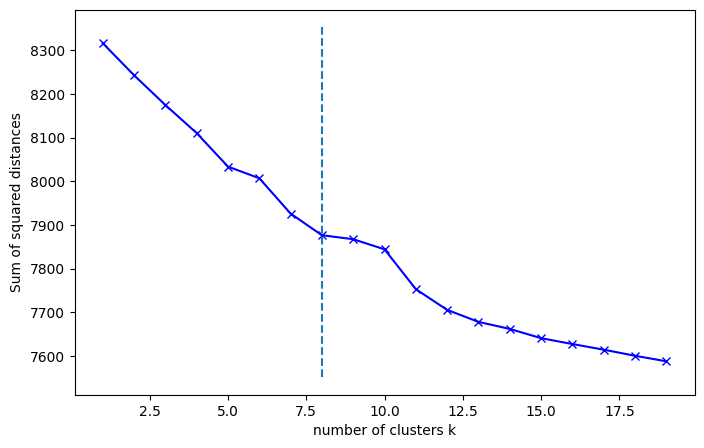

In [ ]:
random.seed(0)
np.random.seed(0)

# Initialising an empty list for inertias
inertia = []

# Training K-means classifier for the range of K to evaluate inertias
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(tfidf)
    inertia.append(kmeanModel.inertia_)

# Locating the best number of K
kn = KneeLocator(K, inertia, curve='convex', direction='decreasing')
print(kn.knee)

# Displaying inertias per number of clusters
plt.figure(figsize=(8,5))
plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(K, inertia, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

The choice of 8 clusters is based on the elbow method, where the reduction in within-cluster variance starts to level off around this point. This indicates that adding more clusters would provide minimal improvement while increasing the model's complexity. The init='k-means++' parameter ensures smarter centroid initialization, leading to faster and more stable convergence. Setting max_iter=3000 allows the algorithm sufficient iterations to fully optimize, particularly for complex data. Finally, random_state=0 ensures consistency across multiple runs, making the clustering results reproducible.

In [ ]:
# The chosen number of clusters based on inertias
clusters = 8

# Trainig the model
kmeanModel = KMeans(n_clusters=clusters, init='k-means++', max_iter=300, random_state=0)
mod = kmeanModel.fit_transform(tfidf)

# Adding the column with assigned cluster number
council_df['k_means'] = kmeanModel.predict(tfidf)
council_df.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-34-b1299aad4e2a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  council_df['k_means'] = kmeanModel.predict(tfidf)


,Unnamed: 0,tweet_id,text,author_id,user_username,created_at,sourcetweet_type,sourcetweet_text,lang,year_month,year,month,month_year,k_means
250369,250370,1429743722267283456,barclay fund fossil fuel bank europe join dema...,740486580,cathdrake,2021-08-23 09:54:01+00:00,NaN,NaN,en,2021-08,2021,8,2021-08,4
250370,250371,1429743153259614211,calm crowd gather trafalgar square ahead prote...,16973333,Independent,2021-08-23 09:51:45+00:00,NaN,NaN,en,2021-08,2021,8,2021-08,0
250371,250372,1429743046145585157,barclay fund fossil fuel bank europe join dema...,329588583,GDRNorminton,2021-08-23 09:51:20+00:00,NaN,NaN,en,2021-08,2021,8,2021-08,4
250372,250373,1429742762077921290,useful short read history,1323711113108869125,Valerie4London,2021-08-23 09:50:12+00:00,NaN,NaN,en,2021-08,2021,8,2021-08,0
250373,250374,1429742490970738688,,1400024080951218178,MarcAyres4,2021-08-23 09:49:07+00:00,NaN,NaN,en,2021-08,2021,8,2021-08,0


In [ ]:
# Count the number of tweets assigned to each cluster
council_df['k_means'].value_counts()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
k_means,
0,6492
6,721
3,644
4,193
5,191
2,99
7,87
1,64


The clustering results show a clear imbalance, with one large cluster (6154 tweets) likely representing the most general theme, while a mid-sized cluster (1257 tweets) captures a distinct but still broad category. Several smaller clusters contain a moderate number of tweets, possibly indicating more specific topics, while the smallest clusters may represent niche discussions or outliers.

In [ ]:
# Set the number of clusters
n = 8

# Filter the dataset to create separate DataFrames for each cluster
clusters = {i: council_df[council_df['k_means'] == i] for i in range(n)}

# Create a list of text data from each cluster
cluster_corpus = [clusters[i]['text'].tolist() for i in range(n)]

# Print the list containing text data for each cluster
print(cluster_corpus)


[['calm crowd gather trafalgar square ahead protest follow live', 'useful short read history', '', 'suck', 'protect clean ocean', 'john lewis', 'protester demo london today', 'impossible rebellion start collective power family people age welcome hand heart amp voice system change time stop harm', 'start', 'financial market country world ninth big emitter carbon kick week climate demonstration capital today', 'massive police presence peaceful protest right', 'benign democratic peaceful protest malignant narcissism criminal waste tax payer money m', 'protest london today start week action call new investment fossil fuel read background', 'need trust prefer', 'accept refugee want afghan militant russia cover refugee putin obviously smart president right mb', 'call immediate end new fossil fuel investment chair trafalgar square', 'log complaint callcentre investment fossil fuel hope divest light ipcc recommendation act responsibly amp integrity', 'activist protest', 'stop harm speech drown

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Combine all tweets within each cluster into a single string (supertweet)
for i, cluster in enumerate(cluster_corpus):
    cluster_corpus[i] = ''.join([''.join(tweet) for tweet in cluster])

# Print the combined text for each cluster
print(cluster_corpus)

# Print the number of clusters
print(len(cluster_corpus))


['calm crowd gather trafalgar square ahead protest follow liveuseful short read historysuckprotect clean oceanjohn lewisprotester demo london todayimpossible rebellion start collective power family people age welcome hand heart amp voice system change time stop harmstartfinancial market country world ninth big emitter carbon kick week climate demonstration capital todaymassive police presence peaceful protest rightbenign democratic peaceful protest malignant narcissism criminal waste tax payer money mprotest london today start week action call new investment fossil fuel read backgroundneed trust preferaccept refugee want afghan militant russia cover refugee putin obviously smart president right mbcall immediate end new fossil fuel investment chair trafalgar squarelog complaint callcentre investment fossil fuel hope divest light ipcc recommendation act responsibly amp integrityactivist proteststop harm speech drown momentarily arrival protestorreal police worktell truthbozo think fall a

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Initialize an empty list to store tokens from each cluster
tokens = []

# Process the text in each cluster using spaCy's pipeline
for doc in nlp.pipe(cluster_corpus, batch_size=1000, disable=["ner", "parser"]):
    # Extract words that match the specified POS tags
    tokens_in_doc = [token.text for token in doc if token.pos_ in POS]

    # Append the extracted tokens to the list
    tokens.append(tokens_in_doc)



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Now that we have the tokens we can build the corpus and dictionary for our model
token_df = pd.DataFrame()
token_df['tokens'] = tokens

token_list = tokens
dictionary = Dictionary(token_list)

# Creating the corpus
corpus = [dictionary.doc2bow(doc) for doc in token_list]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA

Hyperparameter tuning is applied to optimize the clustering process and identify the most suitable cluster structure.





/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


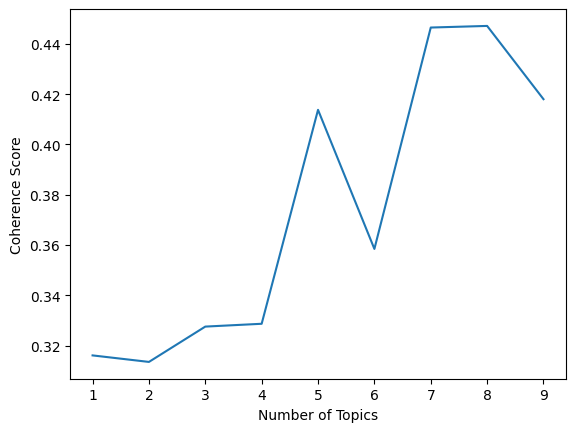

In [ ]:
import matplotlib.pyplot as plt

# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

# Creating lists to store the results of our hyper parameter tests in
topics = []
score = []

# Run the LDA model for 20 different settings, in order to find the best amount of topics
for i in range(1,10,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=50, random_state=0)
    cm = CoherenceModel(model=lda_model, texts = token_list, corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())


# Plot the results
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=4, workers = 4, passes=50, random_state=0)

# Print the topics from the best model
lda_model.print_topics(-1)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.043*"rebellion" + 0.042*"climate" + 0.022*"change" + 0.019*"extinction" + 0.013*"london" + 0.011*"protest" + 0.007*"crisis" + 0.006*"action" + 0.006*"people" + 0.005*"block"'),
 (1,
  '0.020*"let" + 0.020*"energy" + 0.020*"call" + 0.020*"ecocide" + 0.017*"clean" + 0.015*"read" + 0.015*"statement" + 0.015*"day" + 0.014*"commentstrike" + 0.013*"happenlook"'),
 (2,
  '0.011*"amp" + 0.010*"protest" + 0.009*"people" + 0.007*"london" + 0.007*"police" + 0.007*"need" + 0.005*"time" + 0.004*"stop" + 0.004*"world" + 0.004*"planet"'),
 (3,
  '0.039*"fossil" + 0.036*"fuel" + 0.026*"fund" + 0.023*"lie" + 0.020*"amp" + 0.016*"bank" + 0.016*"demand" + 0.015*"real" + 0.015*"stop" + 0.014*"technology"')]

In [ ]:
# Visualizing the data for LDA

lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hyperparameter tuning was performed to determine the optimal number of topics in the LDA model. Initially, coherence scores were used to evaluate different topic numbers. However, it became evident that coherence scores do not always reliably indicate the best topic structure. While they help assess the semantic similarity of words within a topic, they do not guarantee clear topic separation.

To refine the topic selection, a trial-and-error approach was applied, manually inspecting the generated clusters to ensure meaningful and interpretable topics. This process revealed that the best coherence score did not always correspond to the most distinct and usable topics. Ultimately, a 4-topic model was chosen, as it provided the best balance between coherence and interpretability.

Due to computational constraints in Google Colab, hyperparameter tuning had to be limited. A broader search with more iterations and passes might have further improved the results.

### Tuning without 10 most common words

In topic modeling, highly frequent words can dominate the distribution, making it harder to distinguish thematic differences between topics. To improve topic differentiation, the 10 most common words were removed from the analysis. This allows less frequent but more meaningful terms to have a greater impact on topic identification. The following section discusses how this approach has influenced the results.

In [ ]:
from collections import Counter
from gensim.corpora import Dictionary

# Flatten the list of tokenized texts into a single list of words
all_tokens = [word for tokens in token_list for word in tokens]

# Count word frequencies
word_freq = Counter(all_tokens)

# Get the 10 most common words and store them separately
common_words = {word for word, _ in word_freq.most_common(10)}
removed_words = list(common_words)  # Store the removed words

# Remove these words from the tokenized text
filtered_tokens = [[word for word in tokens if word not in common_words] for tokens in token_list]

# Remove empty lists
filtered_tokens = [tokens for tokens in filtered_tokens if tokens]

# Check if filtering worked properly
print("Example of filtered tokens (first 3 entries):", filtered_tokens[:3])
print("Top 10 removed words:", removed_words)

# Update the dictionary and corpus AFTER filtering
dictionary = Dictionary(filtered_tokens)
corpus = [dictionary.doc2bow(text) for text in filtered_tokens]


Example of filtered tokens (first 3 entries): [['calm', 'crowd', 'gather', 'trafalgar', 'square', 'follow', 'liveuseful', 'short', 'read', 'historysuckprotect', 'clean', 'oceanjohn', 'lewisprotester', 'demo', 'todayimpossible', 'start', 'collective', 'power', 'family', 'age', 'welcome', 'hand', 'heart', 'voice', 'system', 'change', 'time', 'harmstartfinancial', 'market', 'country', 'world', 'ninth', 'big', 'emitter', 'carbon', 'kick', 'week', 'demonstration', 'capital', 'todaymassive', 'presence', 'peaceful', 'rightbenign', 'democratic', 'peaceful', 'malignant', 'narcissism', 'criminal', 'waste', 'tax', 'payer', 'money', 'mprotest', 'today', 'start', 'week', 'action', 'call', 'new', 'investment', 'read', 'backgroundneed', 'trust', 'preferaccept', 'refugee', 'want', 'afghan', 'militant', 'russia', 'cover', 'refugee', 'putin', 'smart', 'president', 'right', 'mbcall', 'immediate', 'end', 'new', 'investment', 'chair', 'trafalgar', 'squarelog', 'complaint', 'callcentre', 'investment', 'hope

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


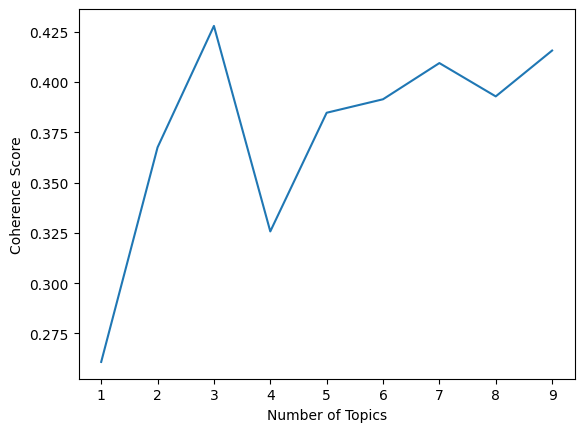

In [ ]:
import matplotlib.pyplot as plt

# Creating lists to store the results of our hyper parameter tests in
topics = []
score = []

# Run the LDA model for 20 different settings, in order to find the best amount of topics
for i in range(1,10,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=50, random_state=0)
    cm = CoherenceModel(model=lda_model, texts = token_list, corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())

# Plot the results
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=3, workers = 4, passes=100, random_state=0)

# Print the topics from the best model
lda_model.print_topics(-1)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.031*"change" + 0.021*"fund" + 0.016*"demand" + 0.013*"bank" + 0.012*"need" + 0.011*"join" + 0.010*"europe" + 0.009*"crisis" + 0.008*"save" + 0.006*"immediatelybarclay"'),
 (1,
  '0.027*"lie" + 0.025*"day" + 0.017*"real" + 0.016*"read" + 0.016*"green" + 0.016*"technology" + 0.011*"monbiot" + 0.011*"emission" + 0.011*"fox" + 0.011*"george"'),
 (2,
  '0.006*"extinction" + 0.005*"time" + 0.005*"need" + 0.005*"action" + 0.004*"block" + 0.004*"energy" + 0.004*"support" + 0.004*"day" + 0.004*"today" + 0.004*"go"')]

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 5. Sentiment analysis

In addition to identifying thematic topics, sentiment analysis is conducted to examine the tone of the online discussions. For this analysis, the Sentiment Intensity Analyser from NLTK is used. This tool calculates a range of sentiment scores for each tweet: negative, neutral, positive, and a combined "compound" score representing the overall sentiment.

The compound score is used to classify tweets. Tweets with a compound score above 0.05 are classified as positive, while scores below -0.05 are classified as negative. Neutral scores, falling within this range, are excluded from further analysis to focus on explicit sentiments. The distribution of sentiments, positive versus negative is analysed for each dataset. The results are linked to events in the Extinction Rebellion timeline to investigate how actions influence public perception. Additionally, visualizations are created to show sentiment trends over time, highlighting shifts in emotions and attitudes.

In [ ]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def sent_scores(col):
    # Calculate sentiment scores for the specified column
    council_df[col + "_neg"] = DF[col].apply(lambda x: sia.polarity_scores(str(x))["neg"])
    council_df[col + "_neu"] = DF[col].apply(lambda x: sia.polarity_scores(str(x))["neu"])
    council_df[col + "_pos"] = DF[col].apply(lambda x: sia.polarity_scores(str(x))["pos"])
    council_df[col + "_compound"] = DF[col].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Apply the function to the 'text' column
sent_scores("text")

# View the results
print(council_df.head())

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-47-cafe1bad01fc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  council_df[col + "_neg"] = DF[col].apply(lambda x: sia.polarity_scores(str(x))["neg"])
<ipython-input-47-cafe1bad01fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

        Unnamed: 0             tweet_id  \
250369      250370  1429743722267283456   
250370      250371  1429743153259614211   
250371      250372  1429743046145585157   
250372      250373  1429742762077921290   
250373      250374  1429742490970738688   

                                                     text  \
250369  barclay fund fossil fuel bank europe join dema...   
250370  calm crowd gather trafalgar square ahead prote...   
250371  barclay fund fossil fuel bank europe join dema...   
250372                          useful short read history   
250373                                                      

                  author_id   user_username                created_at  \
250369            740486580       cathdrake 2021-08-23 09:54:01+00:00   
250370             16973333     Independent 2021-08-23 09:51:45+00:00   
250371            329588583    GDRNorminton 2021-08-23 09:51:20+00:00   
250372  1323711113108869125  Valerie4London 2021-08-23 09:50:12+00:00   
250373  1

<ipython-input-47-cafe1bad01fc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  council_df[col + "_compound"] = DF[col].apply(lambda x: sia.polarity_scores(str(x))["compound"])


In [ ]:
# Calculate the minimum and maximum values of 'text_compound'
min_value = council_df['text_compound'].min()
max_value = council_df['text_compound'].max()

# Print the results
print("Minimum value in text_compound:", min_value)
print("Maximum value in text_compound:", max_value)
def analyze_sentiment_distribution(col):
    # Classify sentiment (positive, negative, neutral)
    council_df['predicted_sentiment'] = council_df[col].apply(lambda x: 1 if x >= 0.05 else (0 if x <= -0.05 else None))

# Remove neutral values
    council_df.dropna(subset=['predicted_sentiment'], inplace=True)

# Calculate distribution
    sentiment_distribution = council_df['predicted_sentiment'].value_counts(normalize=True) * 100

    print(f"Distribution of sentiments in {col}:")
    print(sentiment_distribution)

# Apply to your dataset
analyze_sentiment_distribution('text_compound')

Minimum value in text_compound: -0.981
Maximum value in text_compound: 0.9725
Distribution of sentiments in text_compound:
predicted_sentiment
0.0    55.769793
1.0    44.230207
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-48-bd43d66c3ff8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  council_df['predicted_sentiment'] = council_df[col].apply(lambda x: 1 if x >= 0.05 else (0 if x <= -0.05 else None))
<ipython-input-48-bd43d66c3ff8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc